# Assignment 2
Aman Bhargava -- 1005189733

In [ ]:
# IMPORT BOX #
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tqdm.notebook import tqdm # Progress bars

In [ ]:
# CONSTANTS #
F = 784
H = 32 # Hidden layer size
K = 10

## Provided Data Manipulation Functions

In [ ]:
# Load the data
def loadData():
    with np.load("../datasets/notMNIST.npz") as data:
        Data, Target = data["images"], data["labels"]
        np.random.seed(521193)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        print("DATA DIMENSIONS: ", Data.shape)
        # 14043 = 18724*.75
#         trainData, trainTarget = Data[:10000], Target[:10000]
#         validData, validTarget = Data[10000:16000], Target[10000:16000]
#         testData, testTarget = Data[16000:], Target[16000:]
        trainData, trainTarget = Data[:14043], Target[:14043]
        validData, validTarget = Data[14043:], Target[14043:]
        testData, testTarget = Data[14043:], Target[14043:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget


In [ ]:
# Implementation of a neural network using only Numpy - trained using gradient descent with momentum
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))

    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest

In [ ]:
def shuffle(trainData, trainTarget):
    np.random.seed(421)
    randIndx = np.arange(len(trainData))
    target = trainTarget
    np.random.shuffle(randIndx)
    data, target = trainData[randIndx], target[randIndx]
    return data, target

## 1.1: Helper Functions

In [ ]:
def ReLU(x):
    return np.maximum(x, np.zeros(x.shape))

In [ ]:
def softmax(x):
    x -= x.max() # per 'important hint'.
    factor = np.sum(np.exp(x))
    return np.exp(x)/factor

In [ ]:
def compute(X, W, b):
    np.matmul(W_h, trainData)
    bias=b*np.ones((1,X.shape[1]))
    return np.matmul(W, X)+bias

In [ ]:
def CE(target, prediction):
    return np.sum(target*np.log(prediction))*-1

def averageCE(targets, predictions):
    return (1/np.amax(targets.shape)) * CE(targets, predictions)

In [ ]:
def gradCE(target, prediction):
    f = np.sum(np.exp(prediction))
    return np.exp(prediction)/f - target

## Learning

In [ ]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
newtrain, newvalid, newtest = convertOneHot(trainTarget, validTarget, testTarget)


trainData = trainData.reshape(14043, 784)
validData = validData.reshape(validData.shape[0], 784)
testData = testData.reshape(testData.shape[0], 784)

trainData = np.transpose(trainData)
validData = np.transpose(validData)
testData = testData.T

y_train = np.transpose(newtrain)
y_valid = np.transpose(newvalid)
y_test = np.transpose(newtest)

print("Training data shape: \t{}".format(trainData.shape))
print("Validation data shape: \t{}".format(validData.shape))

In [ ]:
def instantiate_NN(F, H, K):
    W_h = np.random.normal(0, 2/(F+H), size=(F,H))
    b_h = np.zeros((1,H))
    W_o = np.random.normal(0, 2/(K+H), size=(H,K))
    b_o = np.zeros((1,K))
    
    W1 = np.append(b_h, W_h, axis=0)
    W2 = np.append(b_o, W_o, axis=0)
    return W1, W2

In [ ]:
W1, W2 = instantiate_NN(F, H, K)

In [ ]:
# TRAINING LOOP #
epochs = 500

W1, W2 = instantiate_NN(F, H, K)

v_W1 = np.ones(W1.shape)*1e-5
v_W2 = np.ones(W2.shape)*1e-5

d_W1 = np.zeros(W1.shape)
d_W2 = np.zeros(W2.shape)

gamma = 0.9
gamma = 0
alpha = 0.1

verbose = True

Xs = trainData
N = Xs.shape[1]
Ys = y_train

train_accs = []
train_losses = []
valid_accs = []
valid_losses = []

## LOOPS ##

for epoch in tqdm(range(epochs)):
    print('=== STARTING EPOCH {} ==='.format(epoch))
    num_correct = 0
    total_loss = 0
    for i in range(N): # This internal loop can be parallelized...
        ### Forward Pass ### 
        # ...
        x0 = Xs[:, i] # Extracting ith training example.
        x0 = np.append(1, x0)
        s1 = W1.T @ x0
        x1 = ReLU(s1)
        x1 = np.append(1, x1)
        s2 = W2.T @ x1
        s2.shape
        p = softmax(s2)

        ### Backward pass ###
        y = Ys[:, i]
        delta2 = p - y
        delta1 = np.multiply((W2[1:,:] @ delta2), (s1 >= 0).astype(int))

        de_dw1 = np.outer(x0, delta1)
        de_dw2 = np.outer(x1, delta2)

        d_W1 += de_dw1
        d_W2 += de_dw2

        ### Documenting batch Statistics ###
        total_loss += CE(y, p)
        if np.argmax(y) == np.argmax(p):
            num_correct += 1

    # Taking AVERAGE gradients for both matrices.
    d_W1 *= (1/N)
    d_W2 *= (1/N)

    # Updating momentum terms.
    v_W1 = v_W1*gamma + alpha*d_W1
    v_W2 = v_W2*gamma + alpha*d_W2

    # Applying gradients
    W1 = W1 - v_W1
    W2 = W2 - v_W2

    # Documenting Epoch Statistics
    train_accs.append(num_correct/N)
    train_losses.append(total_loss/N)

    # Forward Pass on Testing Set -- Should be in EPOCH loop.
    tD = validData.T # Extracting ith training example.
    tD.shape
    tD = np.append(np.ones(tD.shape[0]).reshape(4681,1), tD, axis=1)
    tD.shape
    tD = tD.T

    s1T = W1.T @ tD
    x1T = ReLU(s1T)
    x1T = np.append( (np.ones(4681).reshape(1,4681)) , x1T, axis=0)
    s2T = W2.T @ x1T
    s2T.shape

    for col in range(s2T.shape[1]):
        s2T[:,col] = softmax(s2T[:,col])
    valid_losses.append(averageCE(y_valid, s2T))
    valid_accs.append(np.sum((np.argmax(s2T, axis=0) == np.argmax(y_valid,axis=0)).astype(int))/np.amax(y_valid.shape))
    print('Valid Acc: {}\t\tValid Loss: {}'.format(valid_accs[-1], valid_losses[-1]))
    print('Train Acc: {}\t\tTrain Loss: {}'.format(train_accs[-1], train_losses[-1]))

## Results

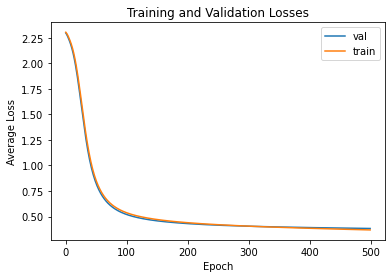

Final Training Loss:  0.36938413843034623
Final Validation Loss:  0.3834529547197975


In [345]:
### Plotting Loss over Time ###
plt.plot(valid_losses, label='val')
plt.plot(train_losses, label='train')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.savefig('Losses.png', dpi=300)
plt.show()

print('Final Training Loss: ', train_losses[-1])
print('Final Validation Loss: ', valid_losses[-1])

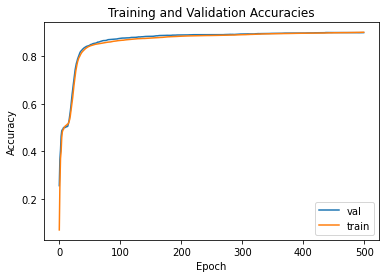

Final Training Accuracy:  0.901445560065513
Final Validation Accuracy:  0.8998077333903012


In [346]:
### Plotting Loss over Time ###
plt.plot(valid_accs, label='val')
plt.plot(train_accs, label='train')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Accuracies.png', dpi=300)
plt.show()

print('Final Training Accuracy: ', train_accs[-1])
print('Final Validation Accuracy: ', valid_accs[-1])

In [347]:
# ### Computing Test Accuracy ###
# # Forward Pass on Testing Set -- Should be in EPOCH loop.
# tD = testData.T # Extracting ith training example.
# tD.shape
# tD = np.append(np.ones(tD.shape[0]).reshape(2724,1), tD, axis=1)
# tD.shape
# tD = tD.T

# s1T = W1.T @ tD
# x1T = ReLU(s1T)
# x1T = np.append( (np.ones(2724).reshape(1,2724)) , x1T, axis=0)
# s2T = W2.T @ x1T
# s2T.shape

# for col in range(s2T.shape[1]):
#     s2T[:,col] = softmax(s2T[:,col])

# test_loss = averageCE(y_test, s2T)
# test_acc = np.sum((np.argmax(s2T, axis=0) == np.argmax(y_test,axis=0)).astype(int))/np.amax(y_test.shape)

In [348]:
# print('Test loss: ', test_loss)
# print('Test acc: ', test_acc)

# Caching Results

 - Learning rate
 - Activation function
 - Save name
 - Losses: 
     - Validation losses
     - Training losses
 - Accuracies:
     - Validation accuracies
     - Training accuracies
 - Train labels
 - Validation labels
 - Training predictions
 - Validation predictions

In [349]:
import uuid
import json
import pickle

output_path = "../results/final/OCR/gradient_descent/"

In [350]:
out_name = "{}{}".format(uuid.uuid1(),".json")
# Printing random id using uuid1()
print ("The random id using uuid1() is : ",end="")
print (out_name)

The random id using uuid1() is : baafa892-bec2-11eb-85f6-f2189895db64.json


## Calculating Train, Validation Probabilities

In [351]:
### Computing TRAIN ACCURACIES ###
# Forward Pass on Testing Set -- Should be in EPOCH loop.
tD = trainData.T # Extracting ith training example.
tD.shape
tD = np.append(np.ones(tD.shape[0]).reshape(14043,1), tD, axis=1)
tD.shape
tD = tD.T

s1T = W1.T @ tD
x1T = ReLU(s1T)
x1T = np.append( (np.ones(14043).reshape(1,14043)) , x1T, axis=0)
s2T = W2.T @ x1T
s2T.shape

for col in range(s2T.shape[1]):
    s2T[:,col] = softmax(s2T[:,col])

train_loss = averageCE(y_train, s2T)
train_acc = np.sum((np.argmax(s2T, axis=0) == np.argmax(y_train,axis=0)).astype(int))/np.amax(y_train.shape)
train_probabilities = s2T.copy()
train_labels = y_train.copy()

In [352]:
### Computing VALIDATION ACCURACIES ###
# Forward Pass on Testing Set -- Should be in EPOCH loop.
tD = validData.T # Extracting ith training example.
tD.shape
tD = np.append(np.ones(tD.shape[0]).reshape(4681,1), tD, axis=1)
tD.shape
tD = tD.T

s1T = W1.T @ tD
x1T = ReLU(s1T)
x1T = np.append( (np.ones(4681).reshape(1,4681)) , x1T, axis=0)
s2T = W2.T @ x1T
s2T.shape

for col in range(s2T.shape[1]):
    s2T[:,col] = softmax(s2T[:,col])

valid_loss = averageCE(y_valid, s2T)
valid_acc = np.sum((np.argmax(s2T, axis=0) == np.argmax(y_valid,axis=0)).astype(int))/np.amax(y_valid.shape)
valid_probabilities = s2T.copy()
valid_labels = y_valid.copy()

## Output Dictionary

In [353]:
output_dict = {
    "learning_rate": alpha,
    "momentum": gamma,
    "hidden_units": H,
    "save_name": "{}.json".format(out_name),
    "losses": train_losses,
    "valid_losses": valid_losses,
    "accuracies": train_accs,
    "valid_accuracies": valid_accs,
    "train_probabilities": train_probabilities,
    "valid_probabilities": valid_probabilities,
    "train_labels": train_labels,
    "valid_labels": valid_labels
}

## Saving Output Dictionary

In [354]:
PTH = "{}{}.pkl".format(output_path, out_name)
PTH

'../results/final/OCR/gradient_descent/baafa892-bec2-11eb-85f6-f2189895db64.json.pkl'

In [355]:
serialized = pickle.dumps(output_dict)

In [356]:
with open(PTH, 'wb') as handle:
    pickle.dump(output_dict, handle)

In [357]:
with open(PTH, 'rb') as handle:
    b = pickle.load(handle)

In [358]:
type(b['train_labels']) # Type test.

numpy.ndarray